# MSc Thesis - Hugo Stam

### Example 04 - Onshore and Offshore Port System Analysis

<img src="Figures/system_layout_alternative_1.2.png" style="width:1000px">
<img src="Figures/system_layout_alternative_2.2.png" style="width:1000px">
<img src="Figures/system_layout_alternative_3.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_onshore as container_system_onshore
from opentisim import container_system_offshore_barge as container_system_offshore_barge
from opentisim import container_system_offshore_bridge as container_system_offshore_bridge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='OGV:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200), 
             ('Medium (250 TEU)', 250), 
             ('Large (300 TEU)', 300)],
    value=250, 
    description='Barge:')

truck = widgets.Dropdown(
    options=[('Small (2 TEU)', 2), 
             ('Medium (2.5 TEU)', 2.5), 
             ('Large (3 TEU)', 3)],
    value=2, 
    description='Truck:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('Input Values')
display(annual_demand, offshore_onshore_distance, container_ship, barge, truck, life_cycle)

Input Values


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

Dropdown(description='Truck:', options=(('Small (2 TEU)', 2), ('Medium (2.5 TEU)', 2.5), ('Large (3 TEU)', 3))…

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
design_truck = truck.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design truck capacity:', design_truck, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design truck capacity: 2 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

In [4]:
# total_ocean_transport = 1000000  # TEU
# years = list(range(startyear, startyear+lifecycle))
# demand_list = []

# for year in years:
#     if year < 2025:
#         demand.append(total_ocean_transport)
#     elif year < 2030:
#         demand.append(total_ocean_transport * 1.5)
#     else:
#         demand.append(total_ocean_transport * 2.0)

# plt.plot(years, demand, 'o')
# plt.ylabel('Demand [TEU]')

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
container_system_onshore.PortSystem = container_system_onshore.System(
                                      startyear = startyear,
                                      lifecycle = lifecycle,
                                      stack_equipment='rs',
                                      laden_stack='rs',
                                      crane_type_defaults=container_defaults.sts_crane_data,
                                      system_layout='traditional_onshore',
                                      allowable_berth_occupancy = 0.70,
                                      transhipment_ratio = 0.0,
                                      elements = demand + vessels,
                                      laden_perc = 0.80, 
                                      reefer_perc = 0.10, 
                                      empty_perc = 0.05, 
                                      oog_perc = 0.05,
                                      operational_hours = 8640,
                                      debug=True)

container_system_offshore_barge.PortSystem = container_system_offshore_barge.System(
                                             startyear = startyear,
                                             lifecycle = lifecycle,
                                             stack_equipment='rs',
                                             laden_stack='rs',
                                             crane_type_defaults=container_defaults.sts_crane_data,
                                             system_layout='offshore_channel',
                                             offshore_distance = offshore_distance,
                                             allowable_berth_occupancy = 0.50,
                                             transhipment_ratio = 0.0,
                                             elements = demand + vessels,
                                             laden_perc = 0.80, 
                                             reefer_perc = 0.10, 
                                             empty_perc = 0.05, 
                                             oog_perc = 0.05,
                                             operational_hours = 8640,
                                             debug=True)

container_system_offshore_bridge.PortSystem = container_system_offshore_bridge.System(
                                             startyear = startyear,
                                             lifecycle = lifecycle,
                                             stack_equipment='rs',
                                             laden_stack='rs',
                                             crane_type_defaults=container_defaults.sts_crane_data,
                                             system_layout='offshore_bridge',
                                             offshore_distance = offshore_distance,
                                             allowable_berth_occupancy = 0.50,
                                             transhipment_ratio = 0.0,
                                             elements = demand + vessels,
                                             laden_perc = 0.80, 
                                             reefer_perc = 0.10, 
                                             empty_perc = 0.05, 
                                             oog_perc = 0.05,
                                             operational_hours = 8640, 
                                             debug=True)

Onshore = container_system_onshore.PortSystem
OffshoreBarge = container_system_offshore_barge.PortSystem
OffshoreBridge = container_system_offshore_bridge.PortSystem

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
Onshore.simulate()
OffshoreBarge.simulate()
OffshoreBridge.simulate()


Onshore Terminal

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0        0.0
1  2021      162

barges_online 9
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020    9000000.0         0.0
1  2021          0.0    900000.0
2  2022          0.0    900000.0
3  2023          0.0    900000.0
4  2024          0.0    900000.0
barges_online 10
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   10000000.0         0.0
1  2021          0.0   1000000.0
2  2022          0.0   1000000.0
3  2023          0.0   1000000.0
4  2024          0.0   1000000.0
barges_online 11
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   11000000.0         0.0
1  2021          0.0   1100000.0
2  2022          0.0   1100000.0
3  2023          0.0   1100000.0
4  2024          0.0   1100000.0
barges_online 12
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   12000000.0         0.0
1  2021          0.0   1200000.0
2  2022          0.0   1200000.0
3  2023          0.0   1200000.0
4  2024          0.0   1200000.0
barges_online 13


c:\checkouts\opentisim\opentisim\container_system_onshore.py:1859: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_onshore.py:2346: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Barge Capex  Barge Opex
0  2020   13000000.0         0.0
1  2021          0.0   1300000.0
2  2022          0.0   1300000.0
3  2023          0.0   1300000.0
4  2024          0.0   1300000.0
barges_online 14
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   14000000.0         0.0
1  2021          0.0   1400000.0
2  2022          0.0   1400000.0
3  2023          0.0   1400000.0
4  2024          0.0   1400000.0
barges_online 15
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   15000000.0         0.0
1  2021          0.0   1500000.0
2  2022          0.0   1500000.0
3  2023          0.0   1500000.0
4  2024          0.0   1500000.0
barges_online 16
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   16000000.0         0.0
1  2021          0.0   1600000.0
2  2022          0.0   1600000.0
3  2023          0.0   1600000.0
4  2024          0.0   1600000.0
barges_online 17
  *** add Barge to elements
df    Year  Barge 

df    Year  Truck Capex  Truck Opex
0  2020     240000.0         0.0
1  2021          0.0     24000.0
2  2022          0.0     24000.0
3  2023          0.0     24000.0
4  2024          0.0     24000.0
truck_online 25
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     250000.0         0.0
1  2021          0.0     25000.0
2  2022          0.0     25000.0
3  2023          0.0     25000.0
4  2024          0.0     25000.0
truck_online 26
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     260000.0         0.0
1  2021          0.0     26000.0
2  2022          0.0     26000.0
3  2023          0.0     26000.0
4  2024          0.0     26000.0
truck_online 27
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     270000.0         0.0
1  2021          0.0     27000.0
2  2022          0.0     27000.0
3  2023          0.0     27000.0
4  2024          0.0     27000.0
truck_online 28
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     620000.0         0.0
1  2021          0.0     62000.0
2  2022          0.0     62000.0
3  2023          0.0     62000.0
4  2024          0.0     62000.0
truck_online 63
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     630000.0         0.0
1  2021          0.0     63000.0
2  2022          0.0     63000.0
3  2023          0.0     63000.0
4  2024          0.0     63000.0
truck_online 64
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     640000.0         0.0
1  2021          0.0     64000.0
2  2022          0.0     64000.0
3  2023          0.0     64000.0
4  2024          0.0     64000.0
truck_online 65
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     650000.0         0.0
1  2021          0.0     65000.0
2  2022          0.0     65000.0
3  2023          0.0     65000.0
4  2024          0.0     65000.0
truck_online 66
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     980000.0         0.0
1  2021          0.0     98000.0
2  2022          0.0     98000.0
3  2023          0.0     98000.0
4  2024          0.0     98000.0
truck_online 99
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     990000.0         0.0
1  2021          0.0     99000.0
2  2022          0.0     99000.0
3  2023          0.0     99000.0
4  2024          0.0     99000.0
truck_online 100
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1000000.0         0.0
1  2021          0.0    100000.0
2  2022          0.0    100000.0
3  2023          0.0    100000.0
4  2024          0.0    100000.0
truck_online 101
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1010000.0         0.0
1  2021          0.0    101000.0
2  2022          0.0    101000.0
3  2023          0.0    101000.0
4  2024          0.0    101000.0
truck_online 102
  *** add Truck to elements
df    Year  Truck

df    Year  Truck Capex  Truck Opex
0  2020    1360000.0         0.0
1  2021          0.0    136000.0
2  2022          0.0    136000.0
3  2023          0.0    136000.0
4  2024          0.0    136000.0
truck_online 137
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1370000.0         0.0
1  2021          0.0    137000.0
2  2022          0.0    137000.0
3  2023          0.0    137000.0
4  2024          0.0    137000.0
truck_online 138
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1380000.0         0.0
1  2021          0.0    138000.0
2  2022          0.0    138000.0
3  2023          0.0    138000.0
4  2024          0.0    138000.0
truck_online 139
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1390000.0         0.0
1  2021          0.0    139000.0
2  2022          0.0    139000.0
3  2023          0.0    139000.0
4  2024          0.0    139000.0
truck_online 140
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1800000.0         0.0
1  2021          0.0    180000.0
2  2022          0.0    180000.0
3  2023          0.0    180000.0
4  2024          0.0    180000.0
truck_online 181
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1810000.0         0.0
1  2021          0.0    181000.0
2  2022          0.0    181000.0
3  2023          0.0    181000.0
4  2024          0.0    181000.0
truck_online 182
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1820000.0         0.0
1  2021          0.0    182000.0
2  2022          0.0    182000.0
3  2023          0.0    182000.0
4  2024          0.0    182000.0
truck_online 183
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1830000.0         0.0
1  2021          0.0    183000.0
2  2022          0.0    183000.0
3  2023          0.0    183000.0
4  2024          0.0    183000.0
truck_online 184
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2140000.0         0.0
1  2021          0.0    214000.0
2  2022          0.0    214000.0
3  2023          0.0    214000.0
4  2024          0.0    214000.0
truck_online 215
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2150000.0         0.0
1  2021          0.0    215000.0
2  2022          0.0    215000.0
3  2023          0.0    215000.0
4  2024          0.0    215000.0
truck_online 216
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2160000.0         0.0
1  2021          0.0    216000.0
2  2022          0.0    216000.0
3  2023          0.0    216000.0
4  2024          0.0    216000.0
truck_online 217
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2170000.0         0.0
1  2021          0.0    217000.0
2  2022          0.0    217000.0
3  2023          0.0    217000.0
4  2024          0.0    217000.0
truck_online 218
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2500000.0         0.0
1  2021          0.0    250000.0
2  2022          0.0    250000.0
3  2023          0.0    250000.0
4  2024          0.0    250000.0
truck_online 251
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2510000.0         0.0
1  2021          0.0    251000.0
2  2022          0.0    251000.0
3  2023          0.0    251000.0
4  2024          0.0    251000.0
truck_online 252
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2520000.0         0.0
1  2021          0.0    252000.0
2  2022          0.0    252000.0
3  2023          0.0    252000.0
4  2024          0.0    252000.0
truck_online 253
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2530000.0         0.0
1  2021          0.0    253000.0
2  2022          0.0    253000.0
3  2023          0.0    253000.0
4  2024          0.0    253000.0
truck_online 254
  *** add Truck to elements
df    Year  Truc

  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4

c:\checkouts\opentisim\opentisim\container_system_onshore.py:1907: FutureWarning:

`item` has been deprecated and will be removed in a future version



df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020       

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84


     Empty Handlers online (@ start of year): 35

  *** add General Services to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021      33319000.0          0.0
2  2022             0.0     499785.0
3  2023             0.0     499785.0
4  2024             0.0     499785.0

Onshore Terminal

Below, the various investment decisions are evaluated for the year 2022.

Simulate year: 2022
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 7 STS_crane is online; 7 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.572
     Berth occupancy online  (@ start of year): 0.572
     Crane occupancy planned (@ start of year): 0.424
 

4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023          

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

     Empty Stack capacity planned  (@ start of year): 2400
     Empty Stack capacity online   (@ start of year): 2400
     Empty Stack capacity required (@ start of year): 2381
     Empty Ground Slots required   (@ start of year): 397

     OOG Slots planned  (@ start of year): 500
     OOG Slots online   (@ start of year): 500
     OOG Slots required (@ start of year): 478

     Number of stack Equipment online (@ start of year): 28

     Gate capacity planned     (@ start of year): 600
     Gate capacity online      (@ start of year): 600
     Gate service rate planned (@ start of year): 0.901
     Gate lane minutes         (@ start of year): 541

     Empty Handlers online (@ start of year): 35


Onshore Terminal

Below, the various investment decisions are evaluated for the year 2026.

Simulate year: 2026
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS 

c:\checkouts\opentisim\opentisim\container_system_onshore.py:573: FutureWarning:

`item` has been deprecated and will be removed in a future version




Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0     

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1859: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2346: FutureWarning:

`item` has been deprecated and will be removed in a future version




barges_online 12
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   12000000.0         0.0
1  2021          0.0   1200000.0
2  2022          0.0   1200000.0
3  2023          0.0   1200000.0
4  2024          0.0   1200000.0
barges_online 13
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   13000000.0         0.0
1  2021          0.0   1300000.0
2  2022          0.0   1300000.0
3  2023          0.0   1300000.0
4  2024          0.0   1300000.0
barges_online 14
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   14000000.0         0.0
1  2021          0.0   1400000.0
2  2022          0.0   1400000.0
3  2023          0.0   1400000.0
4  2024          0.0   1400000.0
barges_online 15
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   15000000.0         0.0
1  2021          0.0   1500000.0
2  2022          0.0   1500000.0
3  2023          0.0   1500000.0
4  2024          0.0   1500000.0
barges_online 1

df    Year  Truck Capex  Truck Opex
0  2020     200000.0         0.0
1  2021          0.0     20000.0
2  2022          0.0     20000.0
3  2023          0.0     20000.0
4  2024          0.0     20000.0
truck_online 21
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     210000.0         0.0
1  2021          0.0     21000.0
2  2022          0.0     21000.0
3  2023          0.0     21000.0
4  2024          0.0     21000.0
truck_online 22
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     220000.0         0.0
1  2021          0.0     22000.0
2  2022          0.0     22000.0
3  2023          0.0     22000.0
4  2024          0.0     22000.0
truck_online 23
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     230000.0         0.0
1  2021          0.0     23000.0
2  2022          0.0     23000.0
3  2023          0.0     23000.0
4  2024          0.0     23000.0
truck_online 24
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     540000.0         0.0
1  2021          0.0     54000.0
2  2022          0.0     54000.0
3  2023          0.0     54000.0
4  2024          0.0     54000.0
truck_online 55
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     550000.0         0.0
1  2021          0.0     55000.0
2  2022          0.0     55000.0
3  2023          0.0     55000.0
4  2024          0.0     55000.0
truck_online 56
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     560000.0         0.0
1  2021          0.0     56000.0
2  2022          0.0     56000.0
3  2023          0.0     56000.0
4  2024          0.0     56000.0
truck_online 57
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     570000.0         0.0
1  2021          0.0     57000.0
2  2022          0.0     57000.0
3  2023          0.0     57000.0
4  2024          0.0     57000.0
truck_online 58
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     890000.0         0.0
1  2021          0.0     89000.0
2  2022          0.0     89000.0
3  2023          0.0     89000.0
4  2024          0.0     89000.0
truck_online 90
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     900000.0         0.0
1  2021          0.0     90000.0
2  2022          0.0     90000.0
3  2023          0.0     90000.0
4  2024          0.0     90000.0
truck_online 91
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     910000.0         0.0
1  2021          0.0     91000.0
2  2022          0.0     91000.0
3  2023          0.0     91000.0
4  2024          0.0     91000.0
truck_online 92
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     920000.0         0.0
1  2021          0.0     92000.0
2  2022          0.0     92000.0
3  2023          0.0     92000.0
4  2024          0.0     92000.0
truck_online 93
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020    1260000.0         0.0
1  2021          0.0    126000.0
2  2022          0.0    126000.0
3  2023          0.0    126000.0
4  2024          0.0    126000.0
truck_online 127
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1270000.0         0.0
1  2021          0.0    127000.0
2  2022          0.0    127000.0
3  2023          0.0    127000.0
4  2024          0.0    127000.0
truck_online 128
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1280000.0         0.0
1  2021          0.0    128000.0
2  2022          0.0    128000.0
3  2023          0.0    128000.0
4  2024          0.0    128000.0
truck_online 129
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1290000.0         0.0
1  2021          0.0    129000.0
2  2022          0.0    129000.0
3  2023          0.0    129000.0
4  2024          0.0    129000.0
truck_online 130
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1600000.0         0.0
1  2021          0.0    160000.0
2  2022          0.0    160000.0
3  2023          0.0    160000.0
4  2024          0.0    160000.0
truck_online 161
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1610000.0         0.0
1  2021          0.0    161000.0
2  2022          0.0    161000.0
3  2023          0.0    161000.0
4  2024          0.0    161000.0
truck_online 162
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1620000.0         0.0
1  2021          0.0    162000.0
2  2022          0.0    162000.0
3  2023          0.0    162000.0
4  2024          0.0    162000.0
truck_online 163
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1630000.0         0.0
1  2021          0.0    163000.0
2  2022          0.0    163000.0
3  2023          0.0    163000.0
4  2024          0.0    163000.0
truck_online 164
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1940000.0         0.0
1  2021          0.0    194000.0
2  2022          0.0    194000.0
3  2023          0.0    194000.0
4  2024          0.0    194000.0
truck_online 195
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1950000.0         0.0
1  2021          0.0    195000.0
2  2022          0.0    195000.0
3  2023          0.0    195000.0
4  2024          0.0    195000.0
truck_online 196
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1960000.0         0.0
1  2021          0.0    196000.0
2  2022          0.0    196000.0
3  2023          0.0    196000.0
4  2024          0.0    196000.0
truck_online 197
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1970000.0         0.0
1  2021          0.0    197000.0
2  2022          0.0    197000.0
3  2023          0.0    197000.0
4  2024          0.0    197000.0
truck_online 198
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2280000.0         0.0
1  2021          0.0    228000.0
2  2022          0.0    228000.0
3  2023          0.0    228000.0
4  2024          0.0    228000.0
truck_online 229
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2290000.0         0.0
1  2021          0.0    229000.0
2  2022          0.0    229000.0
3  2023          0.0    229000.0
4  2024          0.0    229000.0
truck_online 230
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2300000.0         0.0
1  2021          0.0    230000.0
2  2022          0.0    230000.0
3  2023          0.0    230000.0
4  2024          0.0    230000.0
truck_online 231
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2310000.0         0.0
1  2021          0.0    231000.0
2  2022          0.0    231000.0
3  2023          0.0    231000.0
4  2024          0.0    231000.0
truck_online 232
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2640000.0         0.0
1  2021          0.0    264000.0
2  2022          0.0    264000.0
3  2023          0.0    264000.0
4  2024          0.0    264000.0
truck_online 265
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2650000.0         0.0
1  2021          0.0    265000.0
2  2022          0.0    265000.0
3  2023          0.0    265000.0
4  2024          0.0    265000.0
truck_online 266
   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per year
     Horizontal Transport online (@ start of year): 0
     Number of STS cranes        (@ start of year): 0

     Stack Capacity planned  (@ start of year): 0
     Stack Capacity online   (@ start of year): 0
     Stack Capacity required (@ start of year): 12912
     Total Laden and Reefer Ground Slots required (@ start of year): 3228

  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0         

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1907: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0


  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
     Empty Handlers online (@ start of year): 0

  *** add Tract

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023          

4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023          

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

     Gate capacity planned     (@ start of year): 600
     Gate capacity online      (@ start of year): 600
     Gate service rate planned (@ start of year): 0.901
     Gate lane minutes         (@ start of year): 541

     Empty Handlers online (@ start of year): 45


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2023.

Simulate year: 2023
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.478
     Berth occupancy online  (@ start of year): 0.478
     Crane occupancy planned (@ start of year): 0.33
     Crane occupancy onli

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:573: FutureWarning:

`item` has been deprecated and will be removed in a future version




Offshore Port System - Bridge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0    

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1859: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:2346: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Barge Capex  Barge Opex
0  2020   11000000.0         0.0
1  2021          0.0   1100000.0
2  2022          0.0   1100000.0
3  2023          0.0   1100000.0
4  2024          0.0   1100000.0
barges_online 12
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   12000000.0         0.0
1  2021          0.0   1200000.0
2  2022          0.0   1200000.0
3  2023          0.0   1200000.0
4  2024          0.0   1200000.0
barges_online 13
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   13000000.0         0.0
1  2021          0.0   1300000.0
2  2022          0.0   1300000.0
3  2023          0.0   1300000.0
4  2024          0.0   1300000.0
barges_online 14
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   14000000.0         0.0
1  2021          0.0   1400000.0
2  2022          0.0   1400000.0
3  2023          0.0   1400000.0
4  2024          0.0   1400000.0
barges_online 15
  *** add Barge to elements
df    Year  Barge 

df    Year  Truck Capex  Truck Opex
0  2020     190000.0         0.0
1  2021          0.0     19000.0
2  2022          0.0     19000.0
3  2023          0.0     19000.0
4  2024          0.0     19000.0
truck_online 20
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     200000.0         0.0
1  2021          0.0     20000.0
2  2022          0.0     20000.0
3  2023          0.0     20000.0
4  2024          0.0     20000.0
truck_online 21
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     210000.0         0.0
1  2021          0.0     21000.0
2  2022          0.0     21000.0
3  2023          0.0     21000.0
4  2024          0.0     21000.0
truck_online 22
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     220000.0         0.0
1  2021          0.0     22000.0
2  2022          0.0     22000.0
3  2023          0.0     22000.0
4  2024          0.0     22000.0
truck_online 23
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     600000.0         0.0
1  2021          0.0     60000.0
2  2022          0.0     60000.0
3  2023          0.0     60000.0
4  2024          0.0     60000.0
truck_online 61
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     610000.0         0.0
1  2021          0.0     61000.0
2  2022          0.0     61000.0
3  2023          0.0     61000.0
4  2024          0.0     61000.0
truck_online 62
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     620000.0         0.0
1  2021          0.0     62000.0
2  2022          0.0     62000.0
3  2023          0.0     62000.0
4  2024          0.0     62000.0
truck_online 63
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     630000.0         0.0
1  2021          0.0     63000.0
2  2022          0.0     63000.0
3  2023          0.0     63000.0
4  2024          0.0     63000.0
truck_online 64
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     940000.0         0.0
1  2021          0.0     94000.0
2  2022          0.0     94000.0
3  2023          0.0     94000.0
4  2024          0.0     94000.0
truck_online 95
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     950000.0         0.0
1  2021          0.0     95000.0
2  2022          0.0     95000.0
3  2023          0.0     95000.0
4  2024          0.0     95000.0
truck_online 96
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     960000.0         0.0
1  2021          0.0     96000.0
2  2022          0.0     96000.0
3  2023          0.0     96000.0
4  2024          0.0     96000.0
truck_online 97
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     970000.0         0.0
1  2021          0.0     97000.0
2  2022          0.0     97000.0
3  2023          0.0     97000.0
4  2024          0.0     97000.0
truck_online 98
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020    1300000.0         0.0
1  2021          0.0    130000.0
2  2022          0.0    130000.0
3  2023          0.0    130000.0
4  2024          0.0    130000.0
truck_online 131
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1310000.0         0.0
1  2021          0.0    131000.0
2  2022          0.0    131000.0
3  2023          0.0    131000.0
4  2024          0.0    131000.0
truck_online 132
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1320000.0         0.0
1  2021          0.0    132000.0
2  2022          0.0    132000.0
3  2023          0.0    132000.0
4  2024          0.0    132000.0
truck_online 133
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1330000.0         0.0
1  2021          0.0    133000.0
2  2022          0.0    133000.0
3  2023          0.0    133000.0
4  2024          0.0    133000.0
truck_online 134
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1660000.0         0.0
1  2021          0.0    166000.0
2  2022          0.0    166000.0
3  2023          0.0    166000.0
4  2024          0.0    166000.0
truck_online 167
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1670000.0         0.0
1  2021          0.0    167000.0
2  2022          0.0    167000.0
3  2023          0.0    167000.0
4  2024          0.0    167000.0
truck_online 168
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1680000.0         0.0
1  2021          0.0    168000.0
2  2022          0.0    168000.0
3  2023          0.0    168000.0
4  2024          0.0    168000.0
truck_online 169
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1690000.0         0.0
1  2021          0.0    169000.0
2  2022          0.0    169000.0
3  2023          0.0    169000.0
4  2024          0.0    169000.0
truck_online 170
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2020000.0         0.0
1  2021          0.0    202000.0
2  2022          0.0    202000.0
3  2023          0.0    202000.0
4  2024          0.0    202000.0
truck_online 203
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2030000.0         0.0
1  2021          0.0    203000.0
2  2022          0.0    203000.0
3  2023          0.0    203000.0
4  2024          0.0    203000.0
truck_online 204
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2040000.0         0.0
1  2021          0.0    204000.0
2  2022          0.0    204000.0
3  2023          0.0    204000.0
4  2024          0.0    204000.0
truck_online 205
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2050000.0         0.0
1  2021          0.0    205000.0
2  2022          0.0    205000.0
3  2023          0.0    205000.0
4  2024          0.0    205000.0
truck_online 206
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2360000.0         0.0
1  2021          0.0    236000.0
2  2022          0.0    236000.0
3  2023          0.0    236000.0
4  2024          0.0    236000.0
truck_online 237
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2370000.0         0.0
1  2021          0.0    237000.0
2  2022          0.0    237000.0
3  2023          0.0    237000.0
4  2024          0.0    237000.0
truck_online 238
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2380000.0         0.0
1  2021          0.0    238000.0
2  2022          0.0    238000.0
3  2023          0.0    238000.0
4  2024          0.0    238000.0
truck_online 239
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2390000.0         0.0
1  2021          0.0    239000.0
2  2022          0.0    239000.0
3  2023          0.0    239000.0
4  2024          0.0    239000.0
truck_online 240
  *** add Truck to elements
df    Year  Truc

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1907: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0


df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
     Empty Stack capacity planned  (@ start of year): 0
     Empty Stack capacity online   (@ start of year): 0
     Empty Stack capacity required (@ start of year): 2381
     Empty Ground Slots required   (@ start of year): 397

  *** add Empty Stack to el

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

     Empty Stack capacity planned  (@ start of year): 2400
     Empty Stack capacity online   (@ start of year): 2400
     Empty Stack capacity required (@ start of year): 2381
     Empty Ground Slots required   (@ start of year): 397

     OOG Slots planned  (@ start of year): 500
     OOG Slots online   (@ start of year): 500
     OOG Slots required (@ start of year): 478

     Number of stack Equipment online (@ start of year): 36

     Gate capacity planned     (@ start of year): 600
     Gate capacity online      (@ start of year): 600
     Gate service rate planned (@ start of year): 0.901
     Gate lane minutes         (@ start of year): 541

     Empty Handlers online (@ start of year): 45


Offshore Port System - Bridge Connection

Below, the various investment decisions are evaluated for the year 2028.

Simulate year: 2028
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Pa

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:573: FutureWarning:

`item` has been deprecated and will be removed in a future version



## 3. Report all elements

In [9]:
if True: 
    for element in Onshore.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.
        
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.
        
if True: 
    for element in OffshoreBridge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1000000
6  2026  1000000
7  2027  1000000
8  2028  1000000
9  2029  1000000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '9bbbd918-1745-11ea-9802-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': '9bbd10b6-1745-11ea-94db-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, '

Truck

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 138000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 1380000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '9c5d5010-1745-11ea-9b43-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    1380000.0         0.0
1  2021          0.0    138000.0
2  2022          0.0    138000.0
3  2023          0.0    138000.0
4  2024          0.0    138000.0
5  2025          0.0    138000.0
6  2026          0.0    138000.0
7  2027          0.0    138000.0
8  2028          0.0    13

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 258000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 2580000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '9cc3f9d8-1745-11ea-bada-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    2580000.0         0.0
1  2021          0.0    258000.0
2  2022          0.0    258000.0
3  2023          0.0    258000.0
4  2024          0.0    258000.0
5  2025          0.0    258000.0
6  2026          0.0    258000.0
7  2027          0.0    258000.0
8  2028          0.0    258000.0


Truck

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 19000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 190000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '9ef66d50-1745-11ea-873c-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020     190000.0         0.0
1  2021          0.0     19000.0
2  2022          0.0     19000.0
3  2023          0.0     19000.0
4  2024          0.0     19000.0
5  2025          0.0     19000.0
6  2026          0.0     19000.0
7  2027          0.0     19000.0
8  2028          0.0     190


{'land_use': 4651.2, 'triggers': [], 'terminal_capex': 1312800, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 116280, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 10000, 'maintenance_perc': 0.1, 'width': 4, 'height': 4, 'length': 20, 'capacity': 320, 'gross_tgs': 18, 'area_factor': 3.23, 'pavement': 200, 'drainage': 50, 'household': 0.1, 'digout_margin': 1.2, 'reefer_factor': 2.33, 'consumption': 4, 'reefer_rack': 3500, 'reefers_present': 0.5, 'year_purchase': [], 'year_online': 2022, 'name': 'RS Stack', 'id': '9fce4722-1745-11ea-9b63-04d3b0b539c4', 'storage_area': 1440.0, 'df':    Year  Terminal Capex  Maintenance        Energy
0  2020             0.


{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 86000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': 'a04561d8-1745-11ea-9b85-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour          Fuel
0  2020             0.0          0.0       0.000000

{'land_use': 4651.2, 'triggers': [], 'terminal_capex': 1312800, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 116280, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 10000, 'maintenance_perc': 0.1, 'width': 4, 'height': 4, 'length': 20, 'capacity': 320, 'gross_tgs': 18, 'area_factor': 3.23, 'pavement': 200, 'drainage': 50, 'household': 0.1, 'digout_margin': 1.2, 'reefer_factor': 2.33, 'consumption': 4, 'reefer_rack': 3500, 'reefers_present': 0.5, 'year_purchase': [], 'year_online': 2022, 'name': 'RS Stack', 'id': 'a30adfb4-1745-11ea-966d-04d3b0b539c4', 'storage_area': 1440.0, 'df':    Year  Terminal Capex  Maintenance        Energy
0  2020             0.0

Tractor-trailer

{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 86000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': 'a38b66a4-1745-11ea-b2a1-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour          Fuel
0  2020             0.0          0.

In [10]:
# scroll_to_current_cell(preserve=True)

In [11]:
# Onshore.terminal_elements_plot()
# OffshoreBarge.terminal_elements_plot()
# OffshoreBridge.terminal_elements_plot()

In [12]:
# Onshore.terminal_capacity_plot()
# OffshoreBarge.terminal_capacity_plot()
# OffshoreBridge.terminal_capacity_plot()

In [13]:
# Onshore.terminal_land_use_plot()
# OffshoreBarge.terminal_land_use_plot()
# OffshoreBridge.terminal_land_use_plot()

In [14]:
# Onshore.storage_area_plot()
# OffshoreBarge.storage_area_plot()
# OffshoreBridge.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
(Onshore.terminal_capex, Onshore.terminal_opex, 
 Onshore.cash_flows, Onshore.cash_flows_df, 
 Onshore.cash_flows_WACC_real_df, Onshore.NPV) = Onshore.net_present_value()

(OffshoreBarge.terminal_capex, OffshoreBarge.terminal_opex, 
 OffshoreBarge.capital_dredging, OffshoreBarge.maintenance_dredging, 
 OffshoreBarge.barge_capex, OffshoreBarge.barge_opex, 
 OffshoreBarge.cash_flows, OffshoreBarge.cash_flows_df, 
 OffshoreBarge.cash_flows_WACC_real_df, OffshoreBarge.NPV) = OffshoreBarge.net_present_value()

(OffshoreBridge.terminal_capex, OffshoreBridge.terminal_opex, 
 OffshoreBridge.bridge_construction, OffshoreBridge.bridge_maintenance_dredging, 
 OffshoreBridge.truck_capex, OffshoreBridge.truck_opex, 
 OffshoreBridge.cash_flows, OffshoreBridge.cash_flows_df, 
 OffshoreBridge.cash_flows_WACC_real_df, OffshoreBridge.NPV) = OffshoreBridge.net_present_value()

In [16]:
# Onshore.terminal_opex_plot(Onshore.cash_flows_df)
# OffshoreBarge.terminal_opex_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.terminal_opex_plot(OffshoreBridge.cash_flows_df)

In [17]:
# Onshore.total_opex_plot(Onshore.cash_flows_df)
# OffshoreBarge.total_opex_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.total_opex_plot(OffshoreBridge.cash_flows_df)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# Onshore.cashflow_plot(Onshore.cash_flows_df)
# OffshoreBarge.cashflow_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.cashflow_plot(OffshoreBridge.cash_flows_df)

In [19]:
terminal_opex_list = ['Maintenance','Insurance','Energy','Labour', 'Fuel']

print('\033[1mFinancial Indication - Onshore Port\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(Onshore.NPV,-3):,}'))
Onshore.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Onshore Port

*** NPV: $ -518,568,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Barge Capex,Barge Opex,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow
2020,7.72258e+07,0,0,3.25e+08,0,3.5245e+08,0,5e+07,0,3e+07,0,-7.72258e+07
2021,2.35405e+08,0,0,0,2.86171e+07,0,3.10341e+07,4.40262e+07,0,3.5221e+07,0,-2.35405e+08
2022,0,3.85258e+07,0,0,2.5198e+07,0,2.73263e+07,0,7.75324e+06,2.32597e+07,0,-3.85258e+07
2023,0,3.39229e+07,0,0,2.21875e+07,0,2.40615e+07,0,6.82692e+06,0,6.82692e+06,-3.39229e+07
2024,0,2.98699e+07,0,0,1.95366e+07,0,2.11867e+07,0,6.01127e+06,0,6.01127e+06,-2.98699e+07
2025,0,2.63012e+07,0,0,1.72025e+07,0,1.86554e+07,0,5.29308e+06,0,5.29308e+06,-2.63012e+07
2026,0,2.31589e+07,0,0,1.51472e+07,0,1.64266e+07,0,4.66068e+06,0,4.66068e+06,-2.31589e+07
2027,0,2.0392e+07,0,0,1.33375e+07,0,1.4464e+07,0,4.10385e+06,0,4.10385e+06,-2.0392e+07
2028,0,1.79556e+07,0,0,1.1744e+07,0,1.27359e+07,0,3.61354e+06,0,3.61354e+06,-1.79556e+07
2029,0,1.58104e+07,0,0,1.03409e+07,0,1.12143e+07,0,3.18181e+06,0,3.18181e+06,-1.58104e+07


In [20]:
print('\033[1mFinancial Indication - Offshore Port (Barge)\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(OffshoreBarge.NPV,-3):,}'))
OffshoreBarge.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Offshore Port (Barge)

*** NPV: $ -1,205,910,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Barge Capex,Barge Opex,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.25e+08,0,3.5245e+08,0,5e+07,0,3e+07,0,-4.52226e+08,0
2021,2.64419e+08,0,0,0,2.86171e+07,0,3.10341e+07,4.40262e+07,0,3.5221e+07,0,-3.37062e+08,0
2022,0,0,0,0,2.5198e+07,0,2.73263e+07,0,7.75324e+06,2.32597e+07,0,-7.794e+07,4.49887e+07
2023,0,0,0,0,2.21875e+07,0,2.40615e+07,0,6.82692e+06,0,6.82692e+06,-6.86281e+07,3.96137e+07
2024,0,0,0,0,1.95366e+07,0,2.11867e+07,0,6.01127e+06,0,6.01127e+06,-6.04287e+07,3.48808e+07
2025,0,0,0,0,1.72025e+07,0,1.86554e+07,0,5.29308e+06,0,5.29308e+06,-5.3209e+07,3.07134e+07
2026,0,0,0,0,1.51472e+07,0,1.64266e+07,0,4.66068e+06,0,4.66068e+06,-4.68518e+07,2.70439e+07
2027,0,0,0,0,1.33375e+07,0,1.4464e+07,0,4.10385e+06,0,4.10385e+06,-4.12542e+07,2.38129e+07
2028,0,0,0,0,1.1744e+07,0,1.27359e+07,0,3.61354e+06,0,3.61354e+06,-3.63254e+07,2.09678e+07
2029,0,0,0,0,1.03409e+07,0,1.12143e+07,0,3.18181e+06,0,3.18181e+06,-3.19854e+07,1.84627e+07


In [21]:
print('\033[1mFinancial Indication - Offshore Port (Bridge)\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(OffshoreBridge.NPV,-3):,}'))
OffshoreBridge.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Offshore Port (Bridge)

*** NPV: $ -1,233,855,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Barge Capex,Barge Opex,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.25e+08,0,3.5245e+08,0,5e+07,0,3e+07,0,-4.59676e+08,0
2021,2.64419e+08,0,0,0,2.86171e+07,0,3.10341e+07,4.40262e+07,0,3.5221e+07,0,-3.30674e+08,0
2022,0,0,0,0,2.5198e+07,0,2.73263e+07,0,7.75324e+06,2.32597e+07,0,-9.55747e+07,4.49887e+07
2023,0,0,0,0,2.21875e+07,0,2.40615e+07,0,6.82692e+06,0,6.82692e+06,-7.05021e+07,3.96137e+07
2024,0,0,0,0,1.95366e+07,0,2.11867e+07,0,6.01127e+06,0,6.01127e+06,-6.20788e+07,3.48808e+07
2025,0,0,0,0,1.72025e+07,0,1.86554e+07,0,5.29308e+06,0,5.29308e+06,-5.46619e+07,3.07134e+07
2026,0,0,0,0,1.51472e+07,0,1.64266e+07,0,4.66068e+06,0,4.66068e+06,-4.81312e+07,2.70439e+07
2027,0,0,0,0,1.33375e+07,0,1.4464e+07,0,4.10385e+06,0,4.10385e+06,-4.23807e+07,2.38129e+07
2028,0,0,0,0,1.1744e+07,0,1.27359e+07,0,3.61354e+06,0,3.61354e+06,-3.73173e+07,2.09678e+07
2029,0,0,0,0,1.03409e+07,0,1.12143e+07,0,3.18181e+06,0,3.18181e+06,-3.28588e+07,1.84627e+07


 Cash Flow Plot - Weighted average cost of capital 


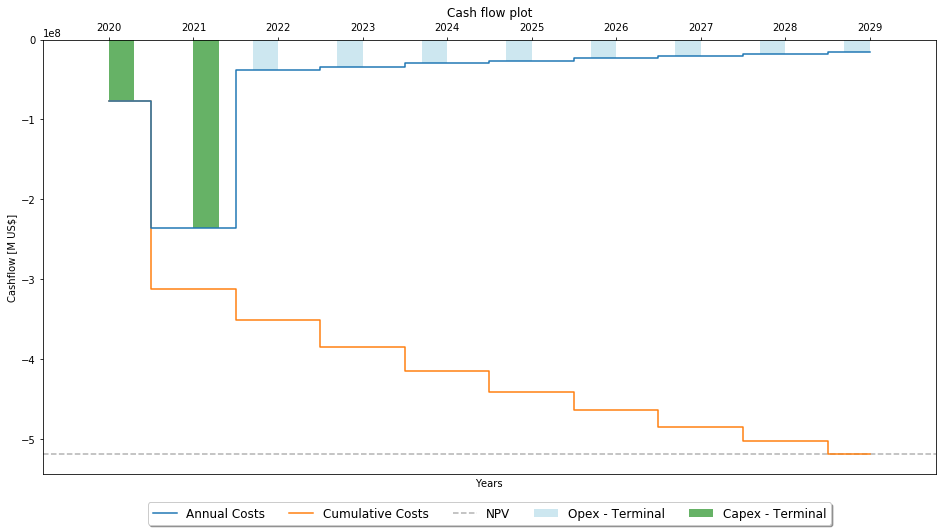

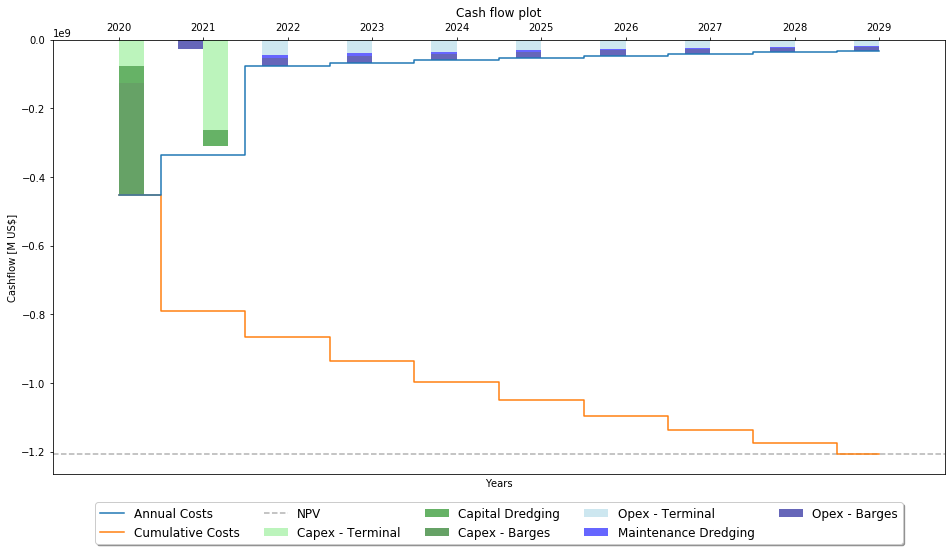

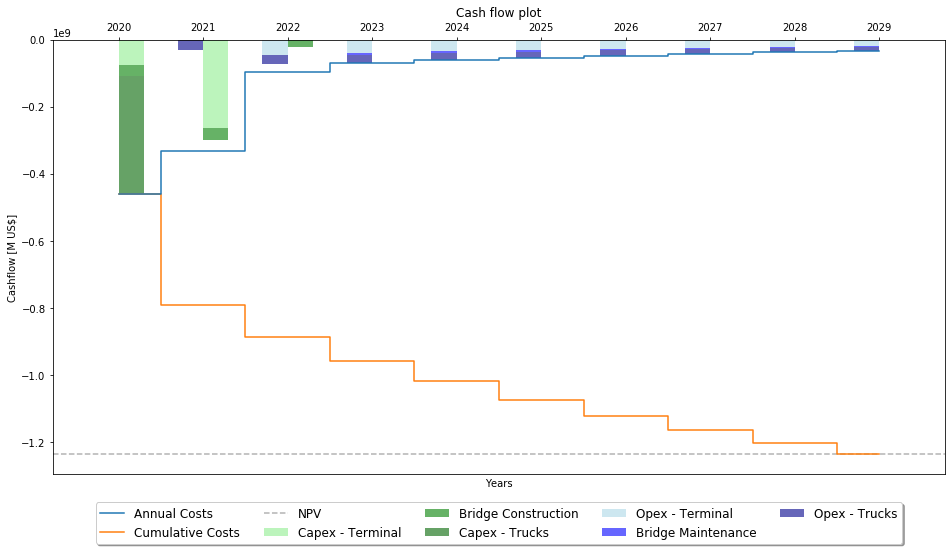

In [22]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
Onshore.cashflow_plot(Onshore.cash_flows_WACC_real_df)
OffshoreBarge.cashflow_plot(OffshoreBarge.cash_flows_WACC_real_df)
OffshoreBridge.cashflow_plot(OffshoreBridge.cash_flows_WACC_real_df)